# Discovery of the p53 targetome in MCF7 cells from RNA-seq data

## Functional analysis of differentially expressed genes

The DESeq2 analysis resulted in a deseq.results.tsv file we will used here. Two replicates of non-stimulated (NS) RNA-seq samples were compared with two replicates of stimulated(S) RNA-seq samples. 

In [3]:
cd /mnt/storage/$USER/jupyternotebooks/RNASeq

Edit deseq.results.tsv file to add Gene in the first column as header.

In [4]:
head deseq.results.tsv

Gene	baseMean	log2FoldChange	lfcSE	stat	pvalue	padj
PLK1	2169.89887036599	-4.73276791052545	0.13660439511827	-34.6457953012998	5.16814761362324e-263	7.98427124828655e-259
CDKN1A	25241.2080295721	4.4868593631955	0.131313746953649	34.168999570009	6.98352056722933e-256	5.39442046215629e-252
CDC20	2087.37990872435	-4.46476556682858	0.132765443258258	-33.628973453157	6.32881904304473e-248	3.25913084653327e-244
TP53INP1	3332.81998084826	4.19869152304937	0.128439177176337	32.6901153943466	2.15823729821513e-234	8.33565200503139e-231
CCNA2	1833.68494342593	-4.66593933645505	0.145290280542013	-32.1146006398263	2.75763794111503e-226	8.52054971045722e-223
KIF20A	2304.20076082827	-4.67958381927593	0.146025361042091	-32.0463773270662	2.46588101336856e-225	6.34923262925515e-222
HMGB2	2441.5235956432	-3.69006024292826	0.123531842999844	-29.8713283418989	4.64012699796811e-196	1.02407602845156e-192
PRC1	3467.82739378419	-3.24682188020529	0.108843688214605	-29.8301346955793	1.58914164982895e-195	3.068831

In [5]:
head -1 deseq.results.tsv  # show the headers
grep -n CDKN1A deseq.results.tsv
grep -n BBC3 deseq.results.tsv
grep -n GDF15 deseq.results.tsv

Gene	baseMean	log2FoldChange	lfcSE	stat	pvalue	padj
3:CDKN1A	25241.2080295721	4.4868593631955	0.131313746953649	34.168999570009	6.98352056722933e-256	5.39442046215629e-252
316:BBC3	562.315816976695	2.69286756902371	0.211416275771203	12.7372765374884	3.66983196161432e-37	1.7998486976184e-35
787:GDF15	4870.22167706625	4.38352677112865	0.54509954481073	8.0416995626931	8.8600906667276e-16	1.74146998359128e-14


# Different types of functional analysis

## 1. Use arbitrary thresholds to create lists of up- and down-regulated genes
* careful: there are a lot of genes without detected expression, they have NA in the logFC column; so column 3 ($3) should not be "NA" 
* we're using awk to filter this file, selecting only rows where the logFC (column 3, indicated by "\$3") is higher than a threshold; and the padj is lower than a threshold
* print ; => prints all the columns of the rows that fulfill our requirements

## Humanmine.org
Create a new list on humanmine.org, then click "Save List of N genes"

    For mouse genes, use mousemine.org
    For Drosophila genes, use flymine.org



Save the name of genes that are significantly upregulated i.e log2FoldChange > 1 and p-adj < 0.05

In [6]:
awk '$3 != "NA" && $3 > 1 && $7 < 0.05 {print $1}' deseq.results.tsv > upRegGenes.txt

Save the name of genes that are significantly downregulated i.e log2FoldChange > 1 and p-adj < 0.05

In [7]:
awk '$3 != "NA" && $3 < -1 && $7 < 0.05 {print $1}' deseq.results.tsv > downRegGenes.txt

Count the numbe of genes in each file

In [8]:
wc -l upRegGenes.txt
wc -l downRegGenes.txt

928 upRegGenes.txt
876 downRegGenes.txt


Create a new list on humanmine.org, then click "Save List of N genes"
* For mouse genes, use mousemine.org
* For Drosophila genes, use flymine.org


Up-regulated genes

Pathway enrichment shows that the p53 signaling pathway is enriched, good ! This means among the up-regulated genes are a significant number of genes that are known to be involved in the p53 pathway.
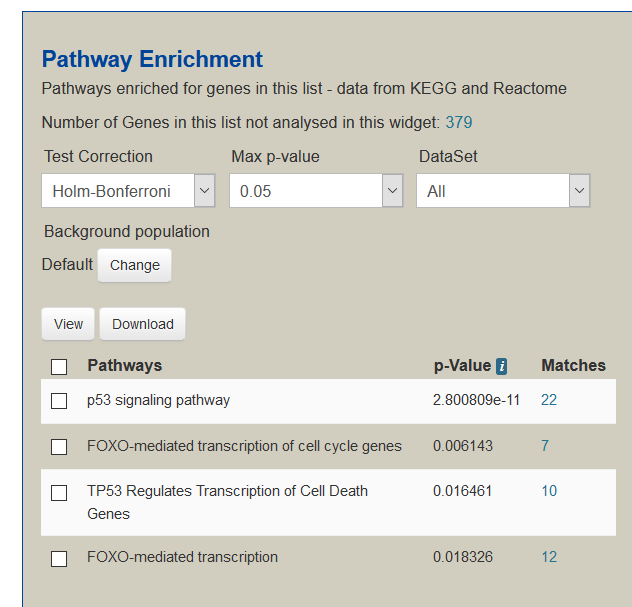

Down-regulated genes

Pathway enrichment show that the genes downregulated by p53 play roles in cell cycle and division.
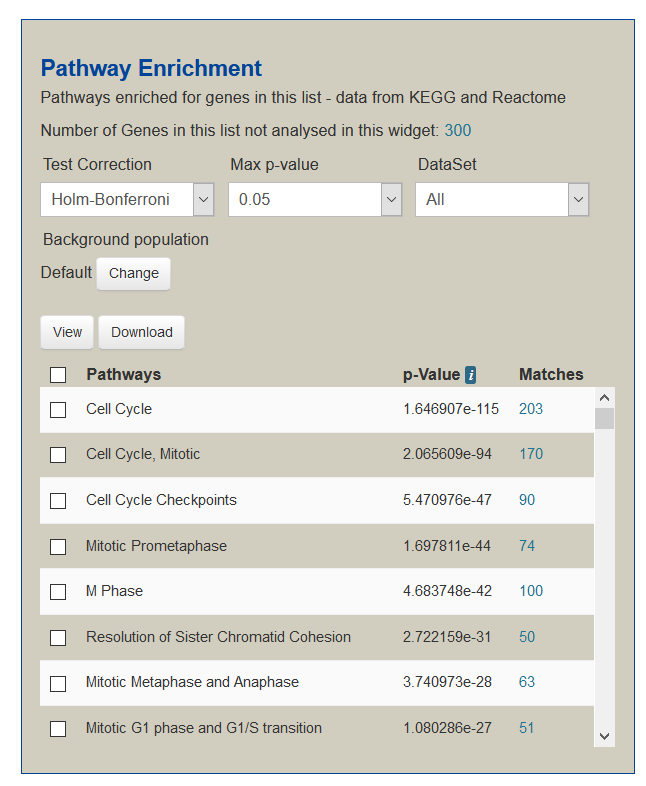

## 2. Use the entire ranking to determine the "leading edge"

### a. GORilla

Sort all genes descending by their logFC or padj; here we use logFC. Write the output to a file

In [9]:
cat deseq.results.tsv | sort -k 3,3gr | awk '$3 != "NA" {print $1}' | grep -v Gene > rankedGenes.txt

Go to http://cbl-gorilla.cs.technion.ac.il/ and enter the text file with ranked gene names, then click on search for enriched GO terms:

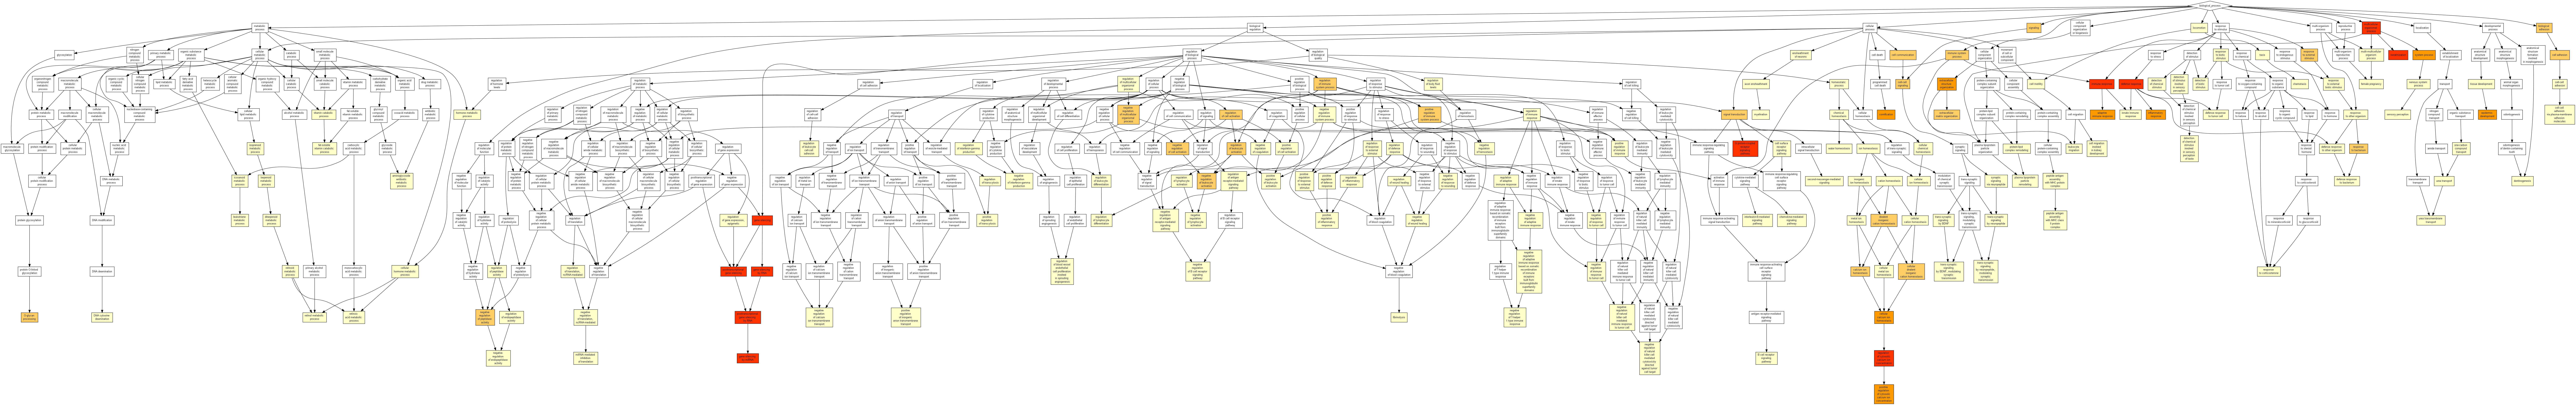

Do the same, but now for a ranked list in ascending order (most down-regulated gene on top):

In [10]:
cat deseq.results.tsv | sort -k3,3g | awk '$3 != "NA" {print $1}' | grep -v Gene > deseq.results.sortFCasc.txt

In [11]:
head deseq.results.sortFCasc.txt 

MIR663B
NMU
MYLK2
NEIL3
RCN3
PIF1
C1QTNF2
SLC30A2
GNB3
MIR548AA1


### b.GSEA : Gene Set Enrichment Analysis

GSEA is often used for a ranking-based enrichment analysis. We will use a standalone version of GSEA, which you can download here: http://software.broadinstitute.org/gsea/index.jsp (click on Downloads; but you need to register first).

* GSEA firstly needs file with the ranked genes, as a .rnk file (just a text file with .rnk extension) with 2 columns: the gene name and the logFC value (the value can also be another type of score, here we use the logFC value).
* GSEA also needs a collection of gene lists, such as gene lists representing GO categories, pathways, etc. For human analyses, lots of collections are available from MSigDB. 
* You can also use your own collection of gene sets, then they need to be formatted in a .gmt file format, see https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats
* In the GSEA software, we will use the GSEAPreranked function to test gene signatures against are preranked gene list (the .rnk file).
* An advantage of GSEA is that both the top of the ranking and the bottom will be tested (while GORilla only tests the top of the ranking; for the bottom we had to reverse the ranking)
* It is VERY important to use a ranking of ALL genes that were measured, not of a gene signature !



Let's first generate a .rnk file

In [13]:
# extract the gene name and logFCvalues for all genes. Write output to a file
cat deseq.results.tsv | sort -k 3,3gr | awk '$3 != "NA" {print $1, $3}' | grep -v Gene | tr ' ' '\t' > deseq.logFC.rnk

In [14]:
head deseq.logFC.rnk

COL17A1	9.05584972880939
RNA5-8SP5	7.81130067309697
AC068057.1	7.23429240632397
MUC19	7.09962808192401
LCE1E	6.82334130801944
TCTEX1D4	6.59523452286397
UNC5B-AS1	6.53036012146373
GABRP	6.40382994329406
APOBEC3C	6.34501263733995
FRMPD2	6.32890774318997


In the gene set database, we have chosen KEGG pathways.
The results are shown below

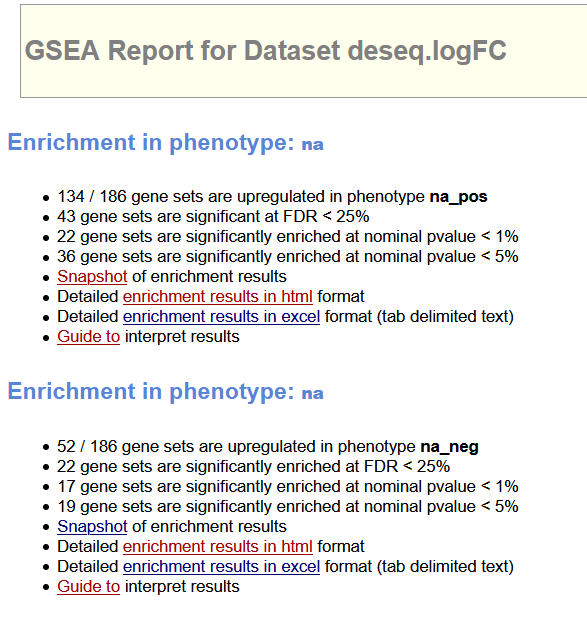

Click on the links "enrichment results in HTML""




Upregulated in stimulated cells
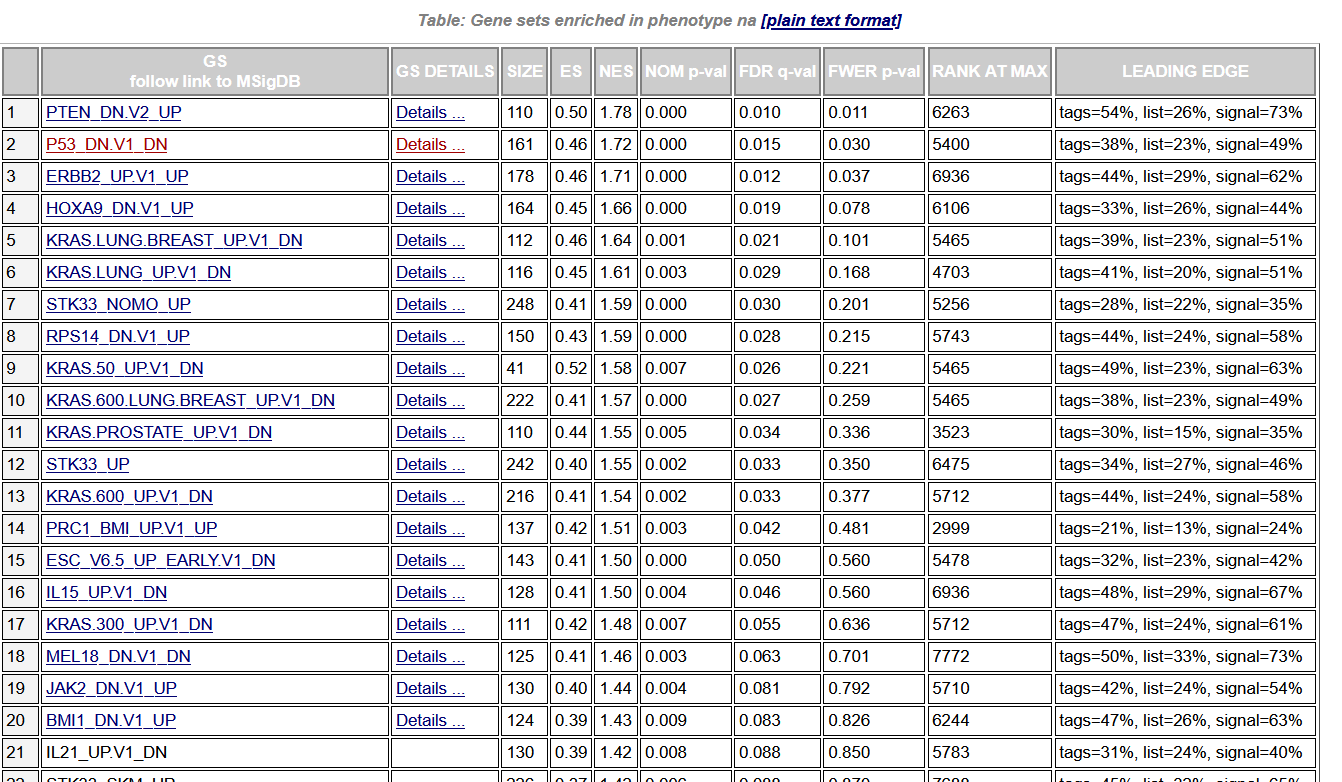

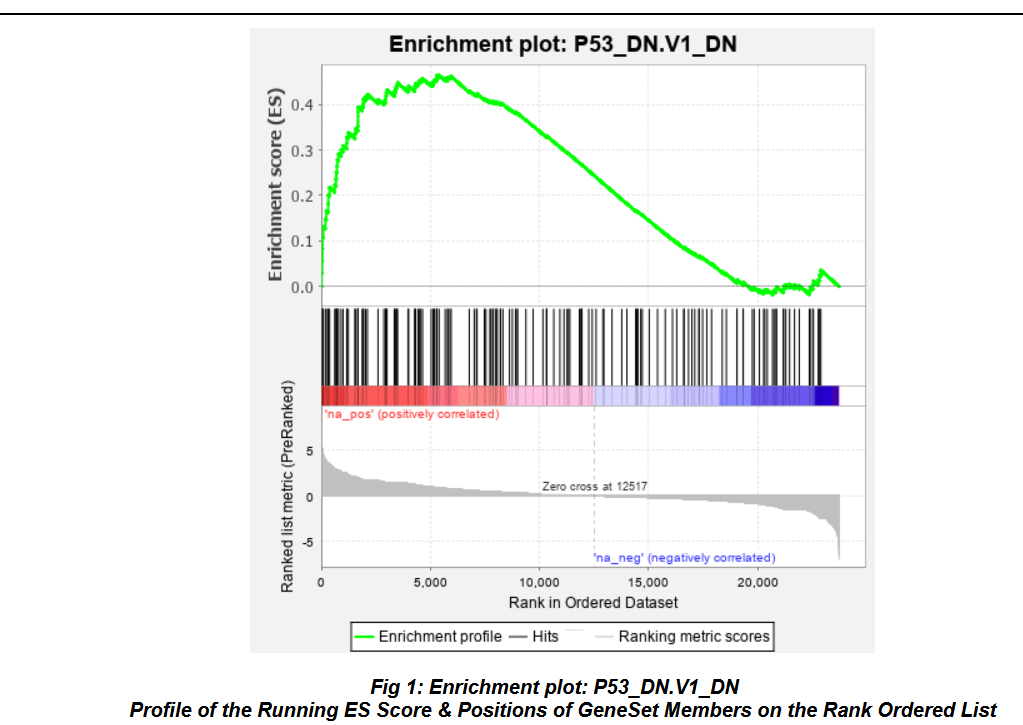

Down-regulated in stimulated cells
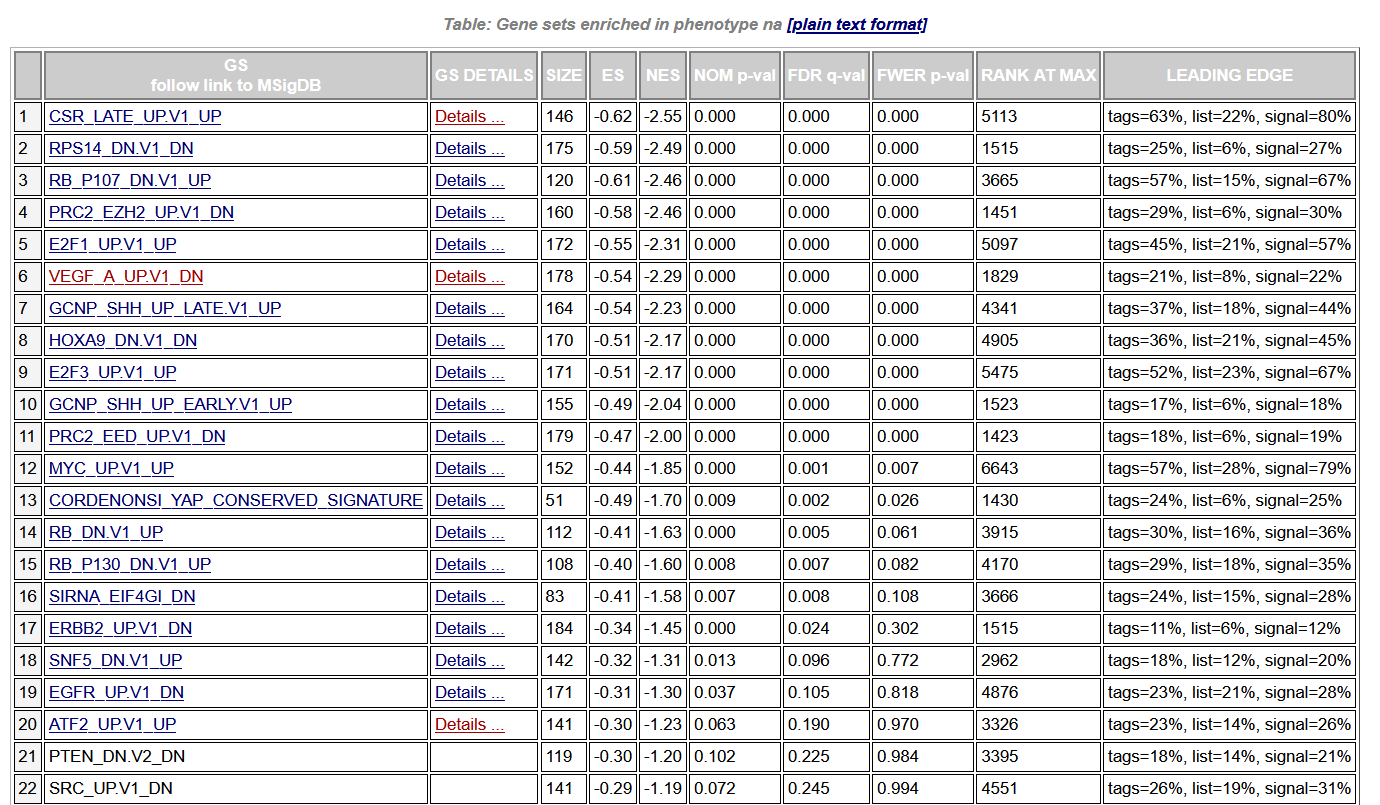

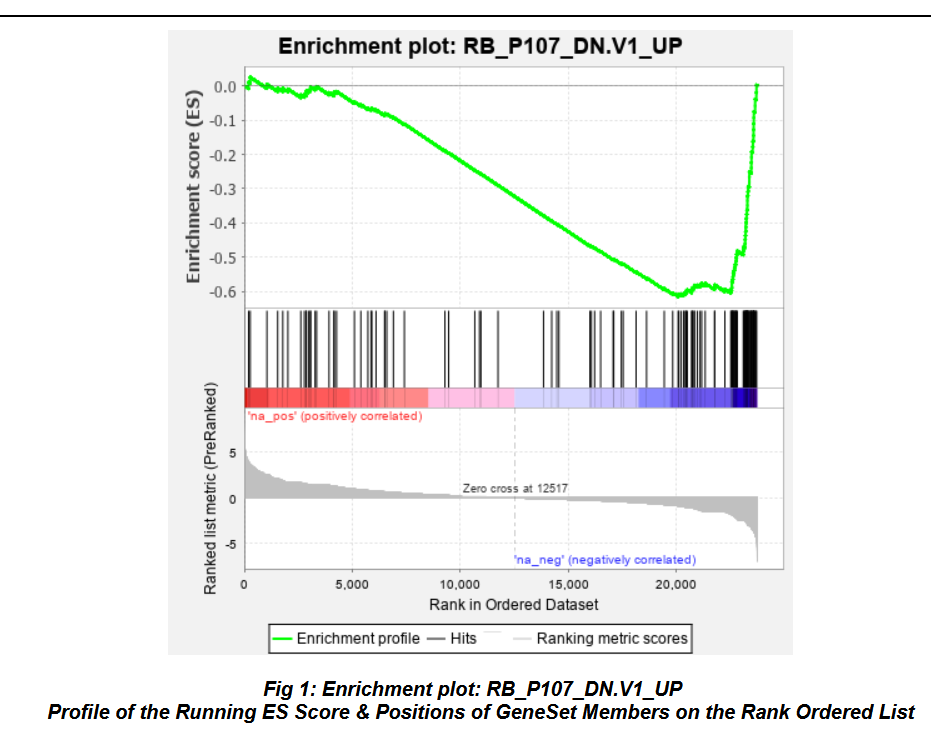